In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import cluster
import os
import re
import sklearn
from datetime import date, datetime
from davies_bouldin import davies_bouldin_score # local
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from MergeDataFrameToTable import MergeDFToTable
try:
    from sklearn.metrics import davies_bouldin_score as db2
    from sklearn.metrics.cluster import v_measure_score as v2
    print('sklearn version qualified, import db score')
except:
    print("use local davies-bouldin score instead")
    pass
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import seaborn as sns
# os.getcwd()
import warnings
import sys 

warnings.filterwarnings('ignore')
print("Sklearn version here:", sklearn.__version__, '\t')
print("python version here:", sys.version, '\t') 
print("pandas version here:", pd.__version__, '\t') 


sklearn version qualified, import db score
Sklearn version here: 0.24.2 	
python version here: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)] 	
pandas version here: 1.4.1 	


In [14]:
def ld_dt(if_local = False):
    if if_local == True:
        link = r'C:\Users\dscshap3808\Documents\my_scripts_new\play1\ou_daily_kpi.csv'
        # link = r'C:\Users\dscshap4085\SFDSC/ou_daily_kpi.csv'
        df = pd.read_csv(link, sep = '\001').fillna(0)
        df.columns =  [re.sub('\w+\.', '', i) for i in df.columns]
    else:
        spark = SparkSession.builder.enableHiveSupport().getOrCreate()
        spark.conf.set('spark.sql.sources.partitionOverwriteMode', 'dynamic')
        """
        load data
        """
        df = spark.sql("""select * from dsc_dws.dws_dsc_wh_ou_daily_kpi_sum where operation_day > '20210901' """)
        # df.show(15,False)
        df = df.select("*").toPandas()
        df = df.fillna(0)
        df = df.replace([np.inf, -np.inf], 0) 
        pass
    df[[
        'inbound_receive_qty', 'outbound_shipped_qty', 'total_working_hour','operation_day'
        ]] = df[[
            'inbound_receive_qty', 'outbound_shipped_qty', 'total_working_hour','operation_day'
            ]].astype(np.int64)

    clean_df2 = df.groupby('ou_code')[[
        'inbound_receive_qty', 'outbound_shipped_qty'
        ]].sum().reset_index()
    clean_df2['sum'] = clean_df2.sum(axis = 1)
    clean_df2 = clean_df2[clean_df2['sum'] != 0]
    df = df[df['ou_code'].isin(clean_df2.ou_code)] 

    clean_df3 = (df.groupby('ou_code')[[
        'total_working_hour'
        ]].sum() == 0).reset_index()
    clean_df3 = clean_df3[clean_df3['total_working_hour'] == False]
    df = df[df['ou_code'].isin(clean_df3.ou_code)]
    df= df.reset_index()

    df = df[[
        'ou_code','operation_day', 'inbound_receive_qty', 'is_holiday',
        'outbound_shipped_qty','total_head_count','total_working_hour',
        'outsource_working_hour', 'perm_working_hour',
        'other_working_hour', 'direct_working_hour', 'indirect_working_hour',
        'outbound_inbound_qty_ratio', 'perm_working_hour_ratio',
        'working_hour_per_head', 'location_usage_rate', 'location_idle_rate']]

    df = df.fillna(0).sort_values('operation_day')
    df = df[df['total_working_hour'] != 0]
    return df

def reshape_to_easy_train(df, col = None):
    """
    reshape dataframe to array
    """
    if type(col) == str:
        return np.reshape(list(df[col]), (-1,1))
    else:
        return np.array(df[col])

In [4]:
def transformer(df,col):
    """
    unfixed stdscaler
    """
    try:
        del mx
    except:
        pass
    mx = StandardScaler()
    df[col] = mx.fit_transform(reshape_to_easy_train(df,col))
    return df
        
def mxscale_(df):
    """
    outlier remove 1
    """
    df['inef'] = df['inbound_receive_qty']  / df['total_working_hour']
    df['ouef'] = df['outbound_shipped_qty'] / df['total_working_hour']
    df['in_out_sum'] = df['outbound_shipped_qty'] + df['inbound_receive_qty']
    df['tt_wh'] = df['total_working_hour']
    for col in ['inef', 'ouef']:
        df = transformer(df,col)
    return df

def drop_outliers(df_train, col = None):
    """
    outlier remove 2
    """
    flag_high = np.mean(df_train[col]) + 1 * np.std(df_train[col])
    flag_low  = np.mean(df_train[col]) - 1 * np.std(df_train[col])
    # print(col, flag_low) 
    df_train['flag_' + col] = np.where(
        (df_train[col] >= flag_low) & (df_train[col] <= flag_high), 
        1, 
        0)
    df_train = df_train[df_train['flag_' + col] != 0]
    return df_train



In [5]:
def get_transformed_data(df_train,  mode = 'train'):
    """
    transform data
    """
    df_train = mxscale_(df_train)
    col = 'inef'
    df_train = drop_outliers(df_train= mxscale_(df_train), col = col) 
    del col
    col = 'ouef'
    df_train = drop_outliers(df_train = df_train, col = col) 
    # print(df_train[['inef','ouef']].tail(20))
    try:
        del mx
    except:
        pass
    mx = StandardScaler()
    mx.fit(
        reshape_to_easy_train(
            df_train,[
                'inbound_receive_qty',
                'outbound_shipped_qty',
                'in_out_sum',
                # 'tt_wh'
                ])
        )
    train_set_inout_transformed = mx.transform(
        reshape_to_easy_train(
            df_train,[
                'inbound_receive_qty',
                'outbound_shipped_qty',
                'in_out_sum',
                # 'tt_wh'
                ])
    )
    df_teste['in_out_sum'] = df_teste['inbound_receive_qty'] + df_teste['outbound_shipped_qty']
    df_teste['tt_wh'] = df_teste['total_working_hour']
    test_set_inout_transformed = mx.transform(
        reshape_to_easy_train(
            df_teste,[
                'inbound_receive_qty',
                'outbound_shipped_qty',
                'in_out_sum',
                # 'tt_wh'
                ])
        )
    if mode != 'train':
        return test_set_inout_transformed
    else:
        return train_set_inout_transformed

In [6]:

def train(df_train, col = 'combined'):
        """
        train
        """
        input = get_transformed_data(df_train, 'train')
        input2= get_transformed_data(df_train, 'teste')
        try:
                del kmeans
        except:
                pass
        # print(input.shape, input2.shape)
        scores = []
        for center in list(range(min_kernel, max_kernel)):
                # kmeans = cluster.MiniBatchKMeans(n_clusters=center, random_state=529)
                # kmeans = cluster.SpectralClustering(n_clusters=center,\
                #         affinity='nearest_neighbors',
                #         n_neighbors=4,
                #         random_state=529, 
                #         n_jobs= -1)
                kmeans = cluster.KMeans(n_clusters=center, random_state = 529)
                model  = kmeans.fit_predict(
                        X = input,
                        )
                
                if pd.Series(model).value_counts().min() <= 2:
                        print("single point in cluster! dropping, center size = %s"%center)
                        score = 100
                        # pass
                else:
                        score  = db2(
                                input,
                                model
                                )
                scores.append(score)
        print(scores,np.array(scores).mean())
        if np.array(scores).mean() == 100:
                raise ValueError('drop cc since score all 100')
        else:
                pass
        center = np.argmin(scores) + min_kernel
        print(center, 'Center count, cap is %s'%max_kernel)
        try:
                del alg1
        except:
                pass
        # alg1 = cluster.SpectralClustering(n_clusters=center,\
        #                 affinity='nearest_neighbors',
        #                 n_neighbors=4,
        #                 random_state=529, 
        #                 n_jobs= -1)
        alg1 = cluster.KMeans(n_clusters=center, random_state = 529)
        hist1 = alg1.fit(
                input 
                )

        k = hist1.predict(
                input2
                )
        return k


# \_\_main__ part of the script

### 对于分布的探索 --------start------

In [152]:
"""
test sinc
"""
df0 = ld_dt(if_local = True)
min_kernel = 3
max_kernel = 11
df_final = pd.DataFrame()

# ['COACHSHSFS', 'COSTASHHTS', 'FERRECDXXS', 'MARSXBJSHS', 'MARSXCDXXS', 'STARBSYXXS',
# 'MARSXJXXWS', 'STARBSHHTS', 'ABBOTCDXXS', 'ABBOTSHDBS', 'ABBOTSZLHS']
# cc = ['COACHSHSFS', 'COSTASHHTS', 'FERRECDXXS', 'MARSXBJSHS', 'MARSXCDXXS', 'STARBSYXXS', 'MARSXJXXWS', 'STARBSHHTS', 'ABBOTCDXXS', 'ABBOTSHDBS', 'ABBOTSZLHS']
# df = df0[df0['ou_code'].isin(cc)]
ou_code =  df0['ou_code'].unique() #'STARBSYXXS', 'FORDCCSLGS'
df = df0

In [153]:
df_t = pd.DataFrame()
for i in ou_code:
    df_train = df[(df['ou_code'] == i)
            & (df['operation_day'] >=  20220101) \
            & (df['operation_day'] <=  20220331) \
            & ((df['inbound_receive_qty'] > 0)
            | (df['outbound_shipped_qty'] > 0))] 
    df_train = df_train.sort_values(['operation_day'], ascending= True)
    df_train = df_train.reset_index(drop=True)
    df_train['inbound_receive_qty'] = df_train['inbound_receive_qty']
    df_train['outbound_shipped_qty'] = df_train['outbound_shipped_qty']
    df_train['temp_qty'] = df_train['inbound_receive_qty'] + df_train['outbound_shipped_qty']
    sub_df = df_train[['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr()
    sub_df['OU'] = i
    df_t = df_t.append(sub_df)
# df_t.to_csv('pearson_correlation_coefficient.csv')  
# df_t  
    
    


In [203]:
from scipy import stats
df_mean_std = pd.DataFrame()
ou_codes = []
mean_ = []
std_ = []
pvalue_ = []
total_count = []
keep_count = []
fail_list = []
for sub_ou in ou_code:
    sub_df = df[(df['ou_code'] == sub_ou)\
            & (df['operation_day'] >=  20220101) 
            & (df['operation_day'] <=  20220331) \
            & ((df['inbound_receive_qty'] > 0)
            | (df['outbound_shipped_qty'] > 0))] 
    sub_df['per_rate'] = (sub_df['inbound_receive_qty'] +  sub_df['outbound_shipped_qty'] * 1.2 ) / sub_df['total_working_hour']
    sub_df = sub_df.sort_values(['operation_day'])
    sub_df = sub_df.reset_index(drop=True)
    u = sub_df['per_rate'].mean()  # 计算均值
    std = sub_df['per_rate'].std()  # 计算标准差
    try: 
        result = stats.kstest(sub_df['per_rate'], 'norm', (u, std))
        if result.pvalue < 0.05:
            for i in range(5) :
                tmp_df = sub_df.loc[(sub_df['per_rate'] <= u + 1.85*std) & (sub_df['per_rate'] >= u - 1.85*std)]
                u = tmp_df['per_rate'].mean()  # 计算均值
                std = tmp_df['per_rate'].std()  # 计算标准差
                result = stats.kstest(tmp_df['per_rate'], 'norm', (u, std))
                
                if result.pvalue >= 0.05:
                    ou_codes.append(sub_ou)
                    total_count.append(sub_df.shape[0])
                    keep_count.append(tmp_df.shape[0])
                    mean_.append(u)
                    std_.append(std)
                    pvalue_.append(result.pvalue)
                    break
        else:
            total_count.append(sub_df.shape[0])
            keep_count.append(sub_df.shape[0])
            ou_codes.append(sub_ou)
            mean_.append(u)
            std_.append(std)
            pvalue_.append(result.pvalue)
    except:
        fail_list = fail_list + [sub_ou]
        
        

In [196]:
df_mean_std = pd.DataFrame()
# ou_codes = []
# mean_ = []
# std_ = []
# pvalue_ = []
df_mean_std['ou_code'] = ou_codes
df_mean_std['mean_'] = mean_
df_mean_std['std_'] = std_
df_mean_std['pvalue_'] = pvalue_
df_mean_std['total_count'] = total_count
df_mean_std['keep_count'] = keep_count

In [200]:
df0['ou_code'].nunique()

131

In [159]:
merge_df = pd.merge(left=df, right=df_mean_std, on='ou_code')
merge_df['predict_by_mean_std'] = (merge_df['inbound_receive_qty'] +  merge_df['outbound_shipped_qty']* 1.2) / merge_df['mean_']
merge_df['predict_by_mean_std_upper'] = (merge_df['inbound_receive_qty'] +  merge_df['outbound_shipped_qty']* 1.2) / (merge_df['mean_'] - 0.5 * merge_df['std_'])
merge_df['predict_by_mean_std_lower'] = (merge_df['inbound_receive_qty'] +  merge_df['outbound_shipped_qty']* 1.2) / (merge_df['mean_'] + 0.5 * merge_df['std_'])

In [192]:
x1 = np.linspace(-150, 150, 15)
# print(stats.kstest(x1, 'norm'))

In [195]:
np.random.seed(10)
a = np.random.normal(1,1,100)
np.random.seed(101)
b= np.random.normal(1,1,3001)
# b
# pd.Series(stats.t.rvs(100, size=100, random_state=15)).hist()
# np.random.seed(1000)
# x2 = np.random.normal(18100)
# print(stats.kstest(x2, 'norm'))
# pd.Series(b).hist()
# stats.kstest(b, 'norm')
stats.kstest(stats.norm.rvs(1,1,100), 'norm', (1,1))
# pd.Series(stats.norm.rvs(1,1,100)).hist()

KstestResult(statistic=0.06703893406984018, pvalue=0.7340614076130803)

In [134]:
merge_df['keep_cnt_rate'] = merge_df['keep_count']/ merge_df['total_count']
merge_df['flag_exceed_upperbound'] = np.where(merge_df['predict_by_mean_std_upper']-merge_df['total_working_hour']>0,0,1)
merge_df['flag_none_nmd'] = np.where(merge_df['pvalue_'] > 0.05, 0, 1)

In [139]:
merge_df[['ou_code', 'operation_day', 'inbound_receive_qty', 'is_holiday',
       'outbound_shipped_qty', 'total_head_count', 'total_working_hour',
       'outsource_working_hour', 'perm_working_hour', 'other_working_hour',
       'mean_', 'std_', 'pvalue_', 'total_count', 'keep_count',
       'predict_by_mean_std', 'predict_by_mean_std_upper',
       'predict_by_mean_std_lower','keep_cnt_rate', 'flag_exceed_upperbound', 'flag_none_nmd']]

,ou_code,operation_day,inbound_receive_qty,is_holiday,outbound_shipped_qty,total_head_count,total_working_hour,outsource_working_hour,perm_working_hour,other_working_hour,...,std_,pvalue_,total_count,keep_count,predict_by_mean_std,predict_by_mean_std_upper,predict_by_mean_std_lower,keep_cnt_rate,flag_exceed_upperbound,flag_none_nmd
0,MARSXCDXXS,20211101,3542855,0,1758469,33.0,295,235.17,60.39,0.0,...,8567.628494,0.352329,143,137,294.661566,379.372537,240.875842,0.958042,0,1
1,MARSXCDXXS,20211102,2208626,0,4325638,34.0,414,328.88,85.43,0.0,...,8567.628494,0.352329,143,137,385.690686,496.571223,315.289063,0.958042,0,1
2,MARSXCDXXS,20211103,1409732,0,5443327,34.0,403,336.55,66.93,0.0,...,8567.628494,0.352329,143,137,413.959593,532.967034,338.397936,0.958042,0,1
3,MARSXCDXXS,20211104,4195083,0,3708437,35.0,394,317.70,76.57,0.0,...,8567.628494,0.352329,143,137,450.628397,580.177593,368.373440,0.958042,0,1
4,MARSXCDXXS,20211105,7979959,0,748380,35.0,359,290.27,68.81,0.0,...,8567.628494,0.352329,143,137,462.763411,595.801250,378.293403,0.958042,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,ABBOTCDXXS,20220328,0,0,18572,6.0,48,16.58,32.26,0.0,...,84.446686,0.124569,96,67,207.370351,341.563738,148.878889,0.697917,0,1
1531,ABBOTCDXXS,20220329,110,0,9312,6.0,49,16.55,32.53,0.0,...,84.446686,0.124569,96,67,104.999012,172.945915,75.382697,0.697917,0,1
1532,ABBOTCDXXS,20220330,0,0,3276,6.0,48,16.38,32.24,0.0,...,84.446686,0.124569,96,67,36.579004,60.249990,26.261428,0.697917,0,1
1533,ABBOTCDXXS,20220331,0,0,999,6.0,48,16.38,31.93,0.0,...,84.446686,0.124569,96,67,11.154587,18.372936,8.008293,0.697917,1,1


In [204]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15515 entries, 0 to 15514
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ou_code                     15515 non-null  object 
 1   operation_day               15515 non-null  int64  
 2   inbound_receive_qty         15515 non-null  int64  
 3   is_holiday                  15515 non-null  int64  
 4   outbound_shipped_qty        15515 non-null  int64  
 5   total_head_count            15515 non-null  float64
 6   total_working_hour          15515 non-null  int64  
 7   outsource_working_hour      15515 non-null  float64
 8   perm_working_hour           15515 non-null  float64
 9   other_working_hour          15515 non-null  float64
 10  direct_working_hour         15515 non-null  float64
 11  indirect_working_hour       15515 non-null  float64
 12  outbound_inbound_qty_ratio  15515 non-null  float64
 13  perm_working_hour_ratio     155

In [26]:
sub_df = df[(df['ou_code'] == 'STARBSYXXS')
            & (df['operation_day'] <=  20220331) \
            & ((df['inbound_receive_qty'] > 0)
            | (df['outbound_shipped_qty'] > 0))] 

In [27]:
sub_df['per_rate'] = (sub_df['inbound_receive_qty'] +  sub_df['outbound_shipped_qty'] * 1.2 ) / sub_df['total_working_hour']

In [28]:
sub_df = sub_df.sort_values(['operation_day'])
sub_df = sub_df.reset_index(drop=True)

In [191]:
from scipy import stats
import pandas as pd
u = sub_df['per_rate'].mean()  # 计算均值
std = sub_df['per_rate'].std()  # 计算标准差
result = stats.kstest(sub_df['per_rate'], 'norm', (u, std))
print(sub_df.shape)
print(result)
for i in range(2) :
    tmp_df = sub_df.loc[(sub_df['per_rate'] <= u + 1.85*std) & (sub_df['per_rate'] >= u - 1.85*std)]
    u = tmp_df['per_rate'].mean()  # 计算均值
    std = tmp_df['per_rate'].std()  # 计算标准差
    result = stats.kstest(tmp_df['per_rate'], 'norm', (u, std))
    print(tmp_df.shape)
    print(result)

(210, 18)
KstestResult(statistic=0.23708997749618577, pvalue=7.196633366495685e-11)
(201, 18)
KstestResult(statistic=0.12538077842238138, pvalue=0.0032614019217325737)
(187, 18)
KstestResult(statistic=0.09030226865739821, pvalue=0.08901541320871031)


In [195]:
print(tmp_df.shape)

(187, 18)


In [198]:
u

880.8618824104766

In [199]:
tmp_df.shape

(187, 18)

In [196]:
std

592.8689369890128

In [154]:
tmp_df[tmp_df['per_rate'] >= (u + std)].shape

(28, 18)

In [155]:
tmp_df[tmp_df['per_rate'] <= (u - std)].shape

(32, 18)

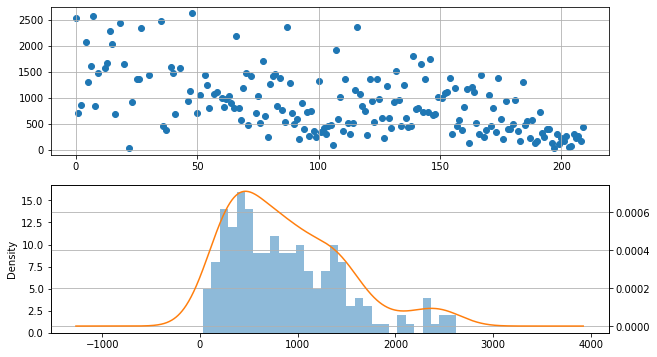

In [197]:
#导入模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#导入scipy模块
from scipy import stats


# 构造一组随机数据
s = tmp_df['per_rate']

# 画散点图和直方图
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)  # 创建子图1
ax1.scatter(s.index, s.values)
plt.grid()

ax2 = fig.add_subplot(2,1,2)  # 创建子图2
s.hist(bins=30,alpha = 0.5,ax = ax2)
s.plot(kind = 'kde', secondary_y=True,ax = ax2)
plt.grid()


In [169]:
tmp_df['outbound_receive_qty']

0      1196874
1      1061413
2      2975665
4      3074121
5       810163
        ...   
192     680765
194    2489300
195     210467
196      31594
197    2531687
Name: inbound_receive_qty, Length: 167, dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 数据准备
s = df_product_size[df_product_size['size'] <80]['size']

# kde=True 会显示一条取值的曲线
sns.distplot(s, kde=True)
plt.show()

In [87]:
df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr('kendall')

# df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr('spearman')

,inbound_receive_qty,outbound_shipped_qty,total_working_hour,temp_qty
inbound_receive_qty,1.000000,0.170760,0.236941,0.560332
outbound_shipped_qty,0.170760,1.000000,0.301992,0.610517
total_working_hour,0.236941,0.301992,1.000000,0.333264
temp_qty,0.560332,0.610517,0.333264,1.000000


In [88]:
# df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr('kendall')

df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr('spearman')

,inbound_receive_qty,outbound_shipped_qty,total_working_hour,temp_qty
inbound_receive_qty,1.000000,0.247132,0.347356,0.726055
outbound_shipped_qty,0.247132,1.000000,0.436466,0.787585
total_working_hour,0.347356,0.436466,1.000000,0.467004
temp_qty,0.726055,0.787585,0.467004,1.000000


In [ ]:
df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr('spearman')

In [97]:
## 弱相关性
df_t = df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr()

In [99]:
type(df_t)

pandas.core.frame.DataFrame

In [100]:
df_t

,inbound_receive_qty,outbound_shipped_qty,total_working_hour,temp_qty
inbound_receive_qty,1.000000,0.151699,0.225929,0.781565
outbound_shipped_qty,0.151699,1.000000,0.348484,0.735167
total_working_hour,0.225929,0.348484,1.000000,0.374886
temp_qty,0.781565,0.735167,0.374886,1.000000


In [76]:
df_train[df_train['ou_code'] == 'STARBSHHTS'][['inbound_receive_qty','outbound_shipped_qty','total_working_hour','temp_qty']].corr()

,inbound_receive_qty,outbound_shipped_qty,total_working_hour,temp_qty
inbound_receive_qty,1.000000,0.151699,0.225929,0.575201
outbound_shipped_qty,0.151699,1.000000,0.348484,0.895803
total_working_hour,0.225929,0.348484,1.000000,0.389993
temp_qty,0.575201,0.895803,0.389993,1.000000


<AxesSubplot:>

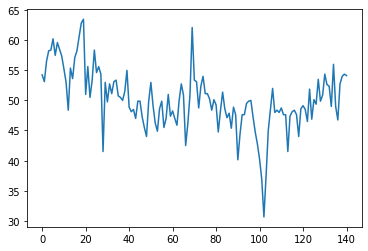

In [65]:
df_train[df_train['ou_code'] == 'STARBSHHTS']['total_working_hour'].plot()

### 对于分布的探索 --------end------

In [24]:

# df0 = ld_dt(if_local = True)
# min_kernel = 3
# max_kernel = 11
df_final = pd.DataFrame()
for ou_code in df['ou_code'].unique(): # --
    df = df0[df0['ou_code'] == ou_code]
    ou_code =  ou_code #'STARBSYXXS', 'FORDCCSLGS' 
    print(ou_code)
    try:
        del df_train,df_nulle,df_teste
    except:
        pass
    df_train = df[(df['ou_code'] == ou_code) \
        & (df['operation_day'] >=  20220101)
        & (df['operation_day'] <=  20220331)
        & ((df['inbound_receive_qty'] > 0)
        | (df['outbound_shipped_qty'] > 0))] # train data for fit, either in or out larger than 0 

    df_nulle = df[(df['ou_code'] == ou_code) \
        # & (df['operation_day'] <  20220201)
        & (df['inbound_receive_qty'] == 0) 
        & (df['outbound_shipped_qty'] == 0)] # null data

    df_teste = df[(df['ou_code'] == ou_code) \
        # & (df['operation_day'] <  20220321)
        & ((df['inbound_receive_qty'] > 0) 
        | (df['outbound_shipped_qty'] > 0))]  # none null data, test set, all time span
    try:
        df_teste['kernels'] = train(df_train)
        df_nulle['kernels'] = -1
        df_fin = pd.concat([df_teste, df_nulle], axis = 0).sort_values('operation_day')
        df_fin = df_fin.join(df_fin[[
            'kernels', 'total_working_hour', 'outsource_working_hour'
            ]].groupby(
                'kernels'
                ).transform('quantile', (.75))\
                    .rename({'total_working_hour':'qt_75_wh', 'outsource_working_hour':'qt_75_os'}, axis = 1))
        df_final = df_final.append(df_fin)
    except:
        print(ou_code, 'has failed in this conversation')

STARBSYXXS
single point in cluster! dropping, center size = 9
single point in cluster! dropping, center size = 10
[0.77113318430713, 0.7516875924675652, 0.7017412365898418, 0.7144398378386946, 0.7772415643279681, 0.7968750291611804, 100, 100] 25.56413980558655
5 Center count, cap is 11
STARBSHHTS
[0.7926023829626699, 0.7053447280633536, 0.6545005042536267, 0.6604232559365378, 0.6841814417089012, 0.7032649483535143, 0.6895902165921264, 0.6720398294975134] 0.6952434134210304
5 Center count, cap is 11


In [1]:
# df_final.to_csv('./starb.csv', index = None)

# preview data

In [2]:
df_fin[['total_working_hour', 'inbound_receive_qty', 'outbound_shipped_qty', 'qt_75_wh', 'kernels','operation_day']]\
    .sort_values('operation_day', ascending = False)\
    .head(50)

In [ ]:
import  matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px


plt = df_fin[['inbound_receive_qty', 'outbound_shipped_qty',  'kernels', 'in_out_sum', 'tt_wh',]]
# sns.scatterplot(x = plt.iloc[:,0],
#                 y = plt.iloc[:,1],
#             hue =plt.iloc[:,2],
#             palette = 'Paired'
#             )
# # pd.DataFrame(input)
px.scatter_3d(data_frame= plt,
              x = 'inbound_receive_qty',
              y = 'outbound_shipped_qty',
              z = 'tt_wh',
              color='kernels',)

# pd.Series(model).value_counts().min()

In [ ]:

df_fin['flag_75_os'] =  df_fin['outsource_working_hour'] -1.2*df_fin['qt_75_os']
df_fin['flag_75_os'] = [1 if a > 0 else 0 for a in df_fin['flag_75_os']]
df_fin['flag_75_wh'] =  df_fin['total_working_hour'] -1.2*df_fin['qt_75_wh']
df_fin['flag_75_wh'] = [1 if a > 0 else 0 for a in df_fin['flag_75_wh']]
df_fin['dis_tt_kernel'] = np.abs(df_fin['total_working_hour'    ]  - 1.2* df_fin['qt_75_wh'] )
df_fin['dis_os_kernel'] = np.abs(df_fin['outsource_working_hour']  - 1.2* df_fin['qt_75_os'] )


# statistical inferencing

In [ ]:
# import sklearn
# from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
mod = sm.OLS(
        endog=df['total_working_hour'],
        exog=df[['inbound_receive_qty','outbound_shipped_qty']])
fii = mod.fit()
# p_values = fii.summary2().tables[1]['P>|t|']
# p_values
fii.summary().tables[1]

In [ ]:
# df_fin[['inbound_receive_qty','outbound_shipped_qty', 'kernels']].query("kernels == 2")

In [ ]:
# select a.ou_code,b.ou_name,b.bg_code,c.bg_name_cn bg_name,operation_day,inbound_receive_qty,outbound_shipped_qty,

# round(total_working_hour,2) total_working_hour,

# round(1.2*qt_75_wh,2) working_hour_limit,round(dis_tt_kernel,2) dis_tt_kernel

In [ ]:

# a = cluster.DBSCAN()
# get_transformed_data('train')
# input = get_transformed_data('train')
# scores = []
# for center in range(3,6):
#         #  np.linspace(0.1, input.max()/2, num=5)
#                 # kmeans = cluster.DBSCAN(eps=center, min_samples=7, n_jobs= -1)
#                 # kmeans = cluster.SpectralClustering(n_clusters=center,\
#                 #         affinity='nearest_neighbors',
#                 #         n_neighbors=4,
#                 #         random_state=529, 
#                 #         n_jobs= -1)
#                 kmeans = cluster.KMeans(n_clusters=center, random_state = 529)
#                 model  = kmeans.fit_predict(
#                         # X = reshape_to_easy_train(df_train, col)
#                         X = input
#                         )
#                 score  = davies_bouldin_score(
#                         # reshape_to_easy_train(df_train, col), 
#                         input,
#                         model
#                         )
#                 scores.append(score)
# scores
# # np.argmin(scores) + 4
# # kmeans = cluster.DBSCAN(eps=.15, min_samples=4, n_jobs= -1)
# # kmeans = cluster.SpectralClustering(n_clusters=4, 
# #                                     affinity='nearest_neighbors',
# #                                     n_neighbors=4,
# #                                     random_state=529, 
# #                                     n_jobs= -1)
# kmeans = cluster.KMeans(n_clusters=np.argmin(scores) + 3)
# model  = kmeans.fit_predict(
#                         # X = reshape_to_easy_train(df_train, col)
#                         X = input
#                         )
# # model.tolist()

In [149]:
import argparse
from datetime import timedelta
args = argparse.ArgumentParser()
args.add_argument("--start_date", help="start date for refresh data, format: yyyyMMdd",\
    default=[(datetime.now() + timedelta(days=-1)).strftime('%Y%m%d')], nargs="*")
args.add_argument("--end_date", help="end date", \
    default=[(datetime.now() + timedelta(days=-91)).strftime('%Y%m%d')], nargs="*")
args.add_argument("--if_local", help = '', default=False, nargs = "*")
args.add_argument("--outb_para", help = '', default=1.2, nargs = "*")

_StoreAction(option_strings=['--outb_para'], dest='outb_para', nargs='*', const=None, default=1.2, type=None, choices=None, help='', metavar=None)

In [150]:

args_parse = args.parse_args()
start_date = args_parse.start_date[0]

usage: ipykernel_launcher.py [-h] [--start_date [START_DATE [START_DATE ...]]]
                             [--end_date [END_DATE [END_DATE ...]]]
                             [--if_local [IF_LOCAL [IF_LOCAL ...]]]
                             [--outb_para [OUTB_PARA [OUTB_PARA ...]]]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"fb2f50f9-cc4d-4dc4-ae9a-dee3656c9bde" --shell=9007 --transport="tcp" --iopub=9009 --f=C:\Users\DSCSHA~1\AppData\Local\Temp\tmp-7340L6uaF1thqjTw.json


SystemExit: 2